In [2]:
%run -i writefile2.py

In [31]:
%%writefile2 --source data_for_country_h.ipynb

"""
gather data for each country, joining the OWID and Oxford data set.
most of this code is plotting.
use owid_outcomes.py, owid_measures.py and indicators.py to describe what data you include.
if you change indicators.py, make sure also to update the 'legend' directory, which
contains the descriptions for indicators (important for the frontend)

"""

import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace as ns
import math
import functools
import require
get_oxford_categorical_flagged = require.single( "get_oxford_categorical_flagged" )
categorical_to_dummy = require.single( "categorical_to_dummy" )
indicators = require.single( "indicators" )
verbose = require.untracked.single( "verbose" )
owid_outcomes = require.single( "owid_outcomes" )
owid_measures = require.single( "owid_measures" )

def compute_data_for_country( country, categorical_as_dummy = True ):

    def plot_all( df, columns = None ):

        if columns is None:

            columns = df.columns

        n_cols = min( 4, len( columns ))
        n_rows = math.ceil( len( columns ) / 4 )
        fig, axs = plt.subplots( n_rows, n_cols, figsize = ( 4 * n_cols, 4 * n_rows ))

        if len( columns ) > 1:
        
            axs = axs.ravel( )
            
        fig.subplots_adjust( hspace = 0.5 )
        
        for i, c in enumerate( columns ):
        
            df[ c ].plot( title = c.replace( '_', ' ' ), ax = axs[ i ])

        #remove unwanted grid cells
        if n_rows > 1:

            for ax in axs[ -(( n_cols * n_rows ) - len( columns )) : ]:

                ax.remove( )

        plt.show( )
    
    if verbose( ):

        display( HTML( f"<h1>{ country }</h1>" ))

    df = read_owid_csv( ).copy( )
    df = df[ df.location == country ]

    # outcomes

    columns = owid_outcomes
    outcome_df = df[ columns ].copy( )

    for c in columns:

        pass
        #outcome_df[ np.isnan( outcome_df[ c ])] = 0

    if verbose( ):

        display( HTML( f"<h3>outcomes</h3>" ))
        plot_all( outcome_df )

    # OWID measures

    columns = owid_measures
    measure_df = df[ columns ].copy( )

    for c in columns:

        measure_df[ c ][ np.isnan( measure_df[ c ])] = 0

    # Oxford measures

    series_per_indicator = { indicator.name: get_oxford_categorical_flagged( country, indicator.name, verbose = False ) for indicator in indicators }

    for indicator in indicators:

        date_offset = 2 # oxford data starts 2 days earlier, just discard it
        measure_df[ indicator.name ] = series_per_indicator[ indicator.name ][ date_offset: ]

    if categorical_as_dummy:

        measure_df = categorical_to_dummy( measure_df )

    if verbose( ):

        url = "https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies"
        display( HTML( f"<h3>measures</h3><p><a href={ url }>see here</a> for an explanation of categorical values</p>" ))
        plot_all( measure_df )

    full_df = pd.concat([ outcome_df, measure_df ], axis = 1 )
    return full_df

@functools.cache
def read_owid_csv( ):

    return pd.read_csv( "data/owid-covid-data.csv", index_col = "date", parse_dates = True, low_memory = False )


In [3]:
%%writefile2

"""
caching node with little additional logic, wrapping compute_data_for_country.py
"""

import nodes
import require

@nodes.store_in_tmp
@nodes.generic_node
def data_for_country( country, categorical_as_dummy = True ):

    compute_data_for_country = require.single( "compute_data_for_country" )
    
    if categorical_as_dummy:

        categorical_to_dummy = require.single( "categorical_to_dummy" )
        
        def main( raw: data_for_country.given( country, categorical_as_dummy = False )):

            return categorical_to_dummy( raw.result )

        return main
        
    else:

        return lambda: compute_data_for_country( country, categorical_as_dummy = False )

node = data_for_country

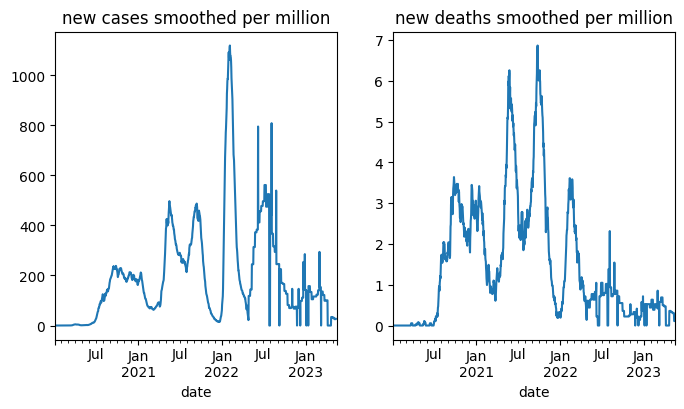

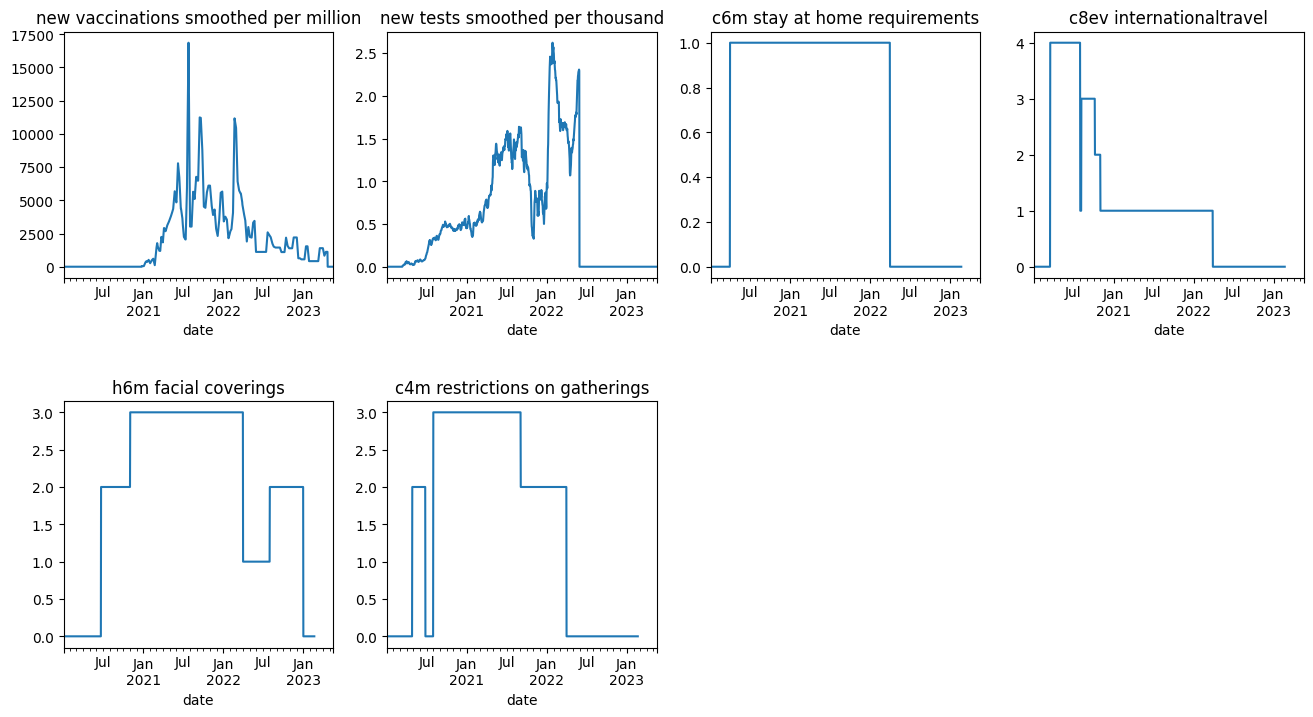

In [6]:
import nodes
import verbose
import require

verbose.set_level( 1 )
country_df = require.single( "compute_data_for_country" )( "Costa Rica", categorical_as_dummy = False )

In [11]:
country_df.columns

Index(['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million',
       'new_vaccinations_smoothed_per_million',
       'new_tests_smoothed_per_thousand', 'c6m_stay_at_home_requirements',
       'c8ev_internationaltravel', 'h6m_facial_coverings',
       'c4m_restrictions_on_gatherings'],
      dtype='object')